In [88]:
import jax.numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from evident_reg.linear_model import GaussianLinear
from evident_reg.maximize import maximize

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
prior_linear_params = multivariate_normal(
    mean=np.array([-3.0]),
    cov=3.*np.ones((1,)),
)
x = np.linspace(0.1, 1, 20)
noise_covariance = np.eye(len(x))

In [91]:
gl = GaussianLinear(
    x=x,
    prior_linear_params = prior_linear_params,
    noise_covariance = noise_covariance,
)

In [92]:
slope, observation = gl.sample()
scale_turn = 0.6
biased_observation = np.where(
        x < scale_turn,
        observation,
        observation[x<scale_turn][-1]
    )

Text(0, 0.5, 'y')

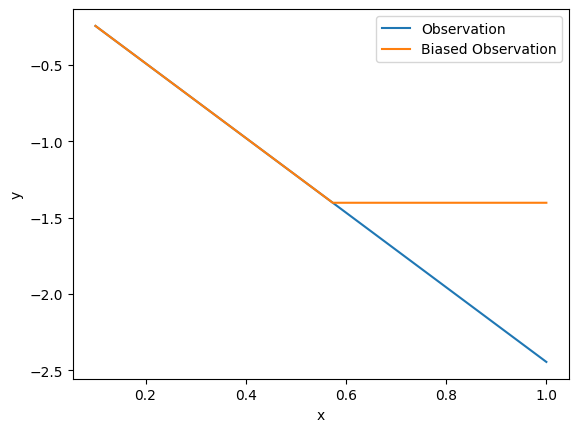

In [93]:
plt.plot(x, observation, label='Observation')
plt.plot(x, biased_observation, label='Biased Observation')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

In [94]:
inverse_noise_covariance = np.linalg.inv(gl.noise_covariance)
fisher_weights = gl.A_matrix.T.dot(inverse_noise_covariance) 

In [95]:
linear_params = np.array([np.linspace(-7.,2,100)]).T
fisher_posterior = gl.get_posterior(
    linear_params=linear_params,
    y=observation, 
    weights=fisher_weights,
)
biased_fisher_posterior = gl.get_posterior(
    linear_params=linear_params,
    y=biased_observation, 
    weights=fisher_weights,
)

In [96]:
print('Evidence for observation no weights = ', 
    gl.get_evidence(
        y=observation,
    )
)
print('Evidence for biased observation no weights = ', 
    gl.get_evidence(
        y=biased_observation,
    )
)

Evidence for observation no weights =  2.0424045e-09
Evidence for biased observation no weights =  1.0122154e-09


In [97]:
print('Evidence for observation fisher weights = ', 
    gl.get_evidence(
        y=observation,
        weights=fisher_weights,
    )
)
print('Evidence for biased observation fisher weights = ', 
    gl.get_evidence(
        y=biased_observation,
        weights=fisher_weights,
    )
)

Evidence for observation fisher weights =  0.028451454
Evidence for biased observation fisher weights =  0.02412014


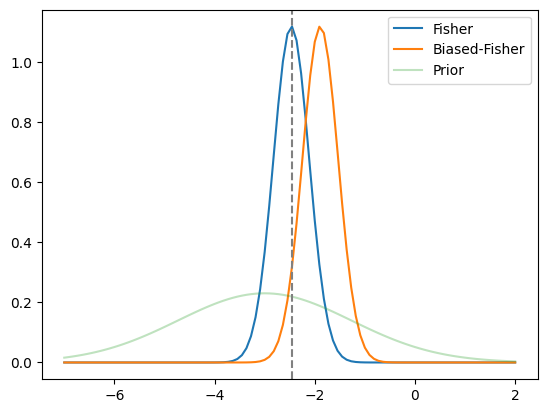

In [98]:
plt.plot(linear_params[:,0], fisher_posterior, label='Fisher')
plt.plot(linear_params[:,0], biased_fisher_posterior, label='Biased-Fisher')
plt.plot(linear_params[:,0], prior_linear_params.pdf(linear_params), label='Prior',
         alpha=0.3)
plt.legend()
plt.axvline(slope, color='gray', linestyle='dashed')

In [99]:
n_embedding = 10 

In [100]:
# test that maximizing fisher recovers analytical expected posterior
initial_weights = np.eye(M=n_embedding, N=len(observation),).T*0.1
numerical_fisher_weights = maximize(
    gl.get_fisher_info,
    weights=initial_weights
)

7.507568
7.84743
7.873435
7.8752975
7.8754344


In [101]:
print('Analytical fisher = ', gl.get_fisher_info(weights=fisher_weights))
print('Numerical fisher = ', gl.get_fisher_info(weights=numerical_fisher_weights))

Analytical fisher =  7.875438
Numerical fisher =  7.87544


In [102]:
numerical_fisher_posterior = gl.get_posterior(
    linear_params=linear_params,
    y=observation, 
    weights=numerical_fisher_weights,
)

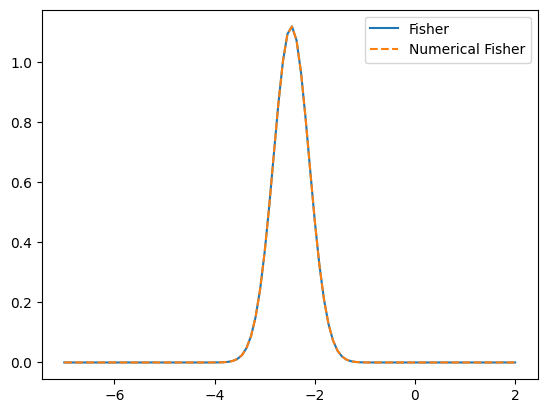

In [103]:
plt.plot(linear_params[:,0], fisher_posterior, label='Fisher')
plt.plot(linear_params[:,0], numerical_fisher_posterior, 
         linestyle='dashed',label='Numerical Fisher')
plt.legend()

In [104]:
# Check analytical vs numerical log evidence ratio

In [105]:
gl.get_evidence_ratio(
    y=observation,
)

DeviceArray(-0.45081353, dtype=float32)

In [106]:
gl.get_evidence_ratio_from_samples(
    y_fiducial=observation,
    y_samples = [gl.sample()[1] for i in range(100)],
)

DeviceArray(0.2881246, dtype=float32)

In [107]:
# Maximize log-evidence ratio + in combination with fisher information

In [108]:
weights_evidence = maximize(
    gl.get_evidence_ratio_from_samples,
    y_fiducial = biased_observation,
    y_samples = [gl.sample()[1] for i in range(100)],
    weights=initial_weights,
    n_epochs=1000,
    learning_rate=0.01,
)
    

0.24783356
0.25634524
0.26073036
0.26334107
0.10650875
0.17139058
0.20558867
0.24272229
0.26727438
0.26818383
0.26184526
-0.04302267
0.20930243
0.2400753
0.26538017
0.26930204
0.26570073
-0.11800185
0.21592456
0.2433684
0.26513246
0.26969463
0.25381264
0.0955448
0.23267668
0.25599545
0.2686648
0.2667703
-0.04042399
0.21237834
0.24672882
0.26045394
0.20905165
0.17523599
0.14241408
0.224795
0.24992797
0.26540273
0.2675721
0.122969106
0.20957766
0.2441071
0.26115212
0.26916796
0.26839396
-0.14860962
0.24161631
0.25679487
0.24444726
0.19455375
0.21013762
0.14554115
0.241288
0.25777996
0.25479308
0.17024721
0.2407725
0.2594536
0.24392805
0.19946226
0.24930532
0.26159796
0.25960055
0.25176576
0.24915889
0.24751605
0.22767885
0.23174597
0.25251892
0.2569142
0.2519952
0.24305601
0.23830184
0.24266618
0.24741507
0.24612544
0.24088532
0.24230896
0.24941607
0.25310996
0.25044546
0.23382355
0.22597262
0.2478691
0.25601262
0.25444922
0.25106043
0.25047013
0.24984689
0.24896766
0.25140166
0.25556475

In [129]:
weights_opt = maximize(
    gl.get_loss,
    y_fiducial = biased_observation,
    y_samples = [gl.sample()[1] for i in range(100)],
    lambda_ev=50.,
    weights=initial_weights,
    n_epochs=1000,
    learning_rate=0.01,

)

19.473347
20.540462
1.7817001
-0.44696903
20.546225
6.8837504
10.892704
7.505951
13.1418495
-1.3757696
5.196622
7.9860544
13.841383
-1.2030258
6.0406013
8.6936245
14.473115
-0.87694263
5.3935432
12.556649
17.540812
19.953045
20.940239
21.333725
21.502962
21.586338
21.633303
21.662373
21.681273
21.693956
21.702662
21.708855
21.713219
21.71645
21.718767
21.72056
21.721893
21.722948
21.723776
21.724407
21.72486
21.725214
21.725187
21.723488
21.711746
21.640312
21.290009
20.74161
21.306946
21.651758
21.708832
21.718678
21.72144
21.722775
21.723648
21.724293
21.724857
21.725243
21.725533
21.72581
21.726051
21.7262
21.726357
21.726393
21.726383
21.726269
21.725843
21.724789
21.722317
21.716478
21.703232
21.674927
21.622494
21.553478
21.517012
21.554422
21.6241
21.67555
21.70269
21.715363
21.721134
21.723862
21.72514
21.72583
21.726202
21.726456
21.726555
21.726688
21.726742
21.72678
21.726841
21.726881
21.726881
21.726921
21.726942
21.72693
21.726982
21.727005
21.72701
21.726992
21.727016
21

In [130]:
evidence_posterior = gl.get_posterior(
    linear_params=linear_params,
    y=biased_observation, 
    weights=weights_evidence,
)
loss_posterior = gl.get_posterior(
    linear_params=linear_params,
    y=biased_observation, 
    weights=weights_opt,
)

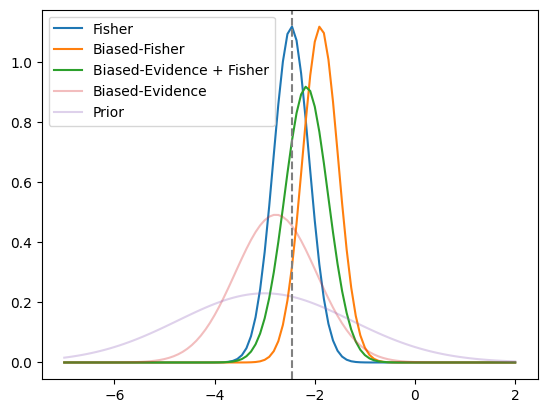

In [137]:
plt.plot(linear_params[:,0], fisher_posterior, label='Fisher')
plt.plot(linear_params[:,0], biased_fisher_posterior, label='Biased-Fisher')
plt.plot(linear_params[:,0], loss_posterior, label='Biased-Evidence + Fisher')
plt.plot(linear_params[:,0], evidence_posterior, label='Biased-Evidence',
         alpha=0.3)
plt.plot(linear_params[:,0], prior_linear_params.pdf(linear_params), label='Prior',
         alpha=0.3)
plt.legend()
plt.axvline(slope, color='gray', linestyle='dashed')

In [138]:
print('Analytical fisher = ', gl.get_fisher_info(weights=fisher_weights))
print('Fisher evidence = ', gl.get_fisher_info(weights=weights_evidence))
print('Fisher combined = ', gl.get_fisher_info(weights=weights_opt))

Analytical fisher =  7.875438
Fisher evidence =  1.5212762
Fisher combined =  5.3010817


In [139]:
print('Evidence fisher = ',     gl.get_evidence(
        y=biased_observation,
        weights=fisher_weights,
    )
)
print('Evidence only = ',     gl.get_evidence(
        y=biased_observation,
        weights=weights_evidence,
    )
)
print('Evidence combined = ',     gl.get_evidence(
        y=biased_observation,
        weights=weights_opt,
    )
)

Evidence fisher =  0.02412014
Evidence only =  752.8156
Evidence combined =  1.5778582e-05


In [140]:
print('Evidence fisher = ',     gl.get_evidence(
        y=observation,
        weights=fisher_weights,
    )
)
print('Evidence only = ',     gl.get_evidence(
        y=observation,
        weights=weights_evidence,
    )
)
print('Evidence combined = ',     gl.get_evidence(
        y=observation,
        weights=weights_opt,
    )
)

Evidence fisher =  0.028451454
Evidence only =  730.9717
Evidence combined =  1.700427e-05


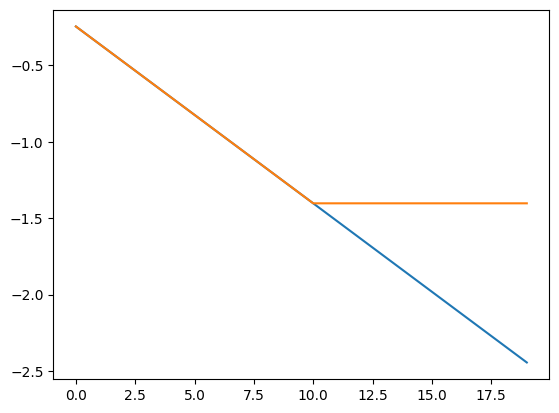

In [141]:
plt.plot(observation)
plt.plot(biased_observation)

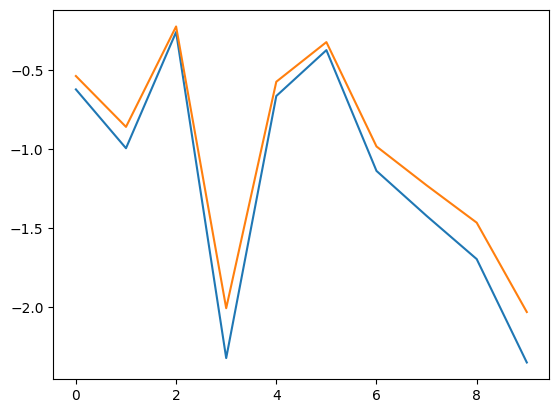

In [142]:
plt.plot(weights_opt.dot(observation))
plt.plot(weights_opt.dot(biased_observation))

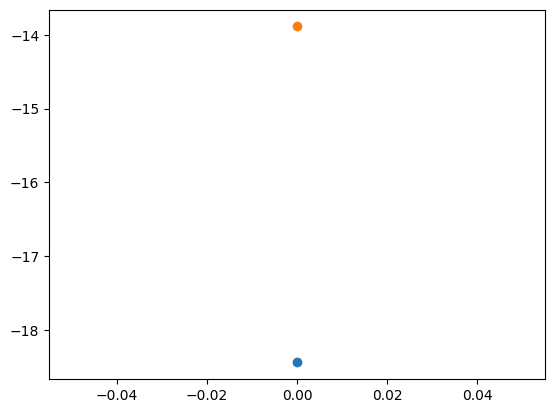

In [143]:
plt.plot(fisher_weights.dot(observation), marker='o')
plt.plot(fisher_weights.dot(biased_observation), marker='o')